# Ocean Carrier Alliances Project - Analysis and Modeling (PNREC Version)

This notebook analyses the PIERS BOL data from the [PIERS Data Project](https://github.com/epistemetrica/PIERS-Data-Project), primarily with the May 23 PNREC conference presentation in mind, but also preparing for later publication(s). Since our initial interest is the impact of alliances on domestic producers, we start by analysing the exports database. 

## Data Import and Transformation

The data come from the PIERS database and are primarily processed in the [PIERS Data Project](https://github.com/epistemetrica/PIERS-Data-Project) with specific preparations for this analysis occuring in the 'oca_data_pred.ipynb' file in this repository. 

In [56]:
#preliminaries 
import pandas as pd #v2.1.3
import numpy as np
import polars as pl #v0.20.18
import plotly_express as px #v0.4.1 
import plotly.graph_objects as go
from datetime import datetime
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

#enable string cache for polars categoricals
pl.enable_string_cache()

#load data to lazyframe
exports_lf = pl.scan_parquet('data/exports/exports.parquet')
imports_lf = pl.scan_parquet('data/imports/*.parquet')

#ignore unused columns 
exports_lf = (
    exports_lf.select(
        'teus',
        'carrier_name',
        'carrier_scac',
        #'vessel_name',
        #'voyage_number',
        'vessel_id',
        'departure_port_code',
        'departure_port_name',
        #'coast_region', #note coast region was restricted to west coast in the data_prep nb
        'hs_code',
        'date',
        #'dest_territory',
        #'dest_region',
        'arrival_port_code',
        'arrival_port_name',
        'direction',
        'bol_id',
        'year',
        'month',
        'lane_id',
        'lane_name',
        'unified_carrier_name',
        'unified_carrier_scac',
        'vessel_owner',
        'primary_cargo',
        'vessel_lane_pair',
        'date_departure'
    )
    #drop 2005-06
    .filter(~pl.col('year').is_in([2005,2006]))
)
imports_lf = (
    imports_lf.select(
        'teus',
        #'date',
        #'origin_territory',
        'origin_region',
        'arrival_port_code',
        'arrival_port_name',
        'departure_port_code',
        'departure_port_name',
        #'coast_region', #note coast region was restricted to west coast in the data_prep nb
        'hs_code',
        'carrier_name',
        'carrier_scac',
        #'vessel_name',
        #'voyage_number',
        'vessel_id',
        'direction',
        'bol_id',
        'year',
        'month',
        'lane_id',
        'lane_name',
        'unified_carrier_name',
        'unified_carrier_scac',
        'vessel_owner',
        'primary_cargo',
        'vessel_lane_pair',
        'date_arrival'
    )
)

### Alliance Membership

Data on which carriers are part of which alliances was collected, where available, from alliance agreements filed with the Federal Maritime Commission. Where primary sources were not available, alliance membership was determined from industry reports and various media sources. 

In [57]:
#load alliance membership data from csv
alliances_df = pl.read_csv('data/misc/exportAlliances.csv', dtypes={'unified_carrier_scac':pl.Categorical, 'date':pl.Datetime}).drop('unified_carrier_name')

In [58]:
#join to exports lf
exports_lf = (
    exports_lf
    .join(alliances_df.lazy(), on=['unified_carrier_scac', 'date'], how='left')
    .with_columns(
        #create boolean for alliance membership
        pl.col('alliance').is_not_null().alias('alliance_member'),
        #set missing alliance_member cells to "Non-alliance Carriers"
        pl.col('alliance').replace({None:'Non-alliance Carriers'})
        )
)

In [59]:
exports_lf.describe()

statistic,teus,carrier_name,carrier_scac,vessel_id,departure_port_code,departure_port_name,hs_code,date,arrival_port_code,arrival_port_name,direction,bol_id,year,month,lane_id,lane_name,unified_carrier_name,unified_carrier_scac,vessel_owner,primary_cargo,vessel_lane_pair,date_departure,alliance,alliance_member
str,f64,str,str,f64,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,f64,str,str,str,f64
"""count""",1.5540806e7,"""15508959""","""15540806""",1.5540806e7,"""15540806""","""15540806""","""15540079""","""15540806""","""15540806""","""15540806""","""15540806""","""15540478""",1.5540806e7,"""15540806""","""15540806""","""15540806""","""15536750""","""15540806""","""15540806""",1.5540806e7,"""15540806""","""15529351""","""15540806""",1.5540806e7
"""null_count""",0.0,"""31847""","""0""",0.0,"""0""","""0""","""727""","""0""","""0""","""0""","""0""","""328""",0.0,"""0""","""0""","""0""","""4056""","""0""","""0""",0.0,"""0""","""11455""","""0""",0.0
"""mean""",4.536686,null,null,9.3481e6,null,null,null,"""2015-05-12 01:…",null,null,null,null,2014.860095,null,null,null,null,null,null,0.635077,null,"""2015-04-25 15:…",null,0.54292
"""std""",7.541837,null,null,224987.284902,null,null,null,null,null,null,null,null,4.625865,null,null,null,null,null,null,null,null,null,null,null
"""min""",0.03,null,null,1.00082e6,null,null,"""0""","""2007-01-01 00:…",null,null,null,"""0_ATL130301550…",2007.0,"""200701""",null,null,null,null,null,0.0,null,"""2005-01-02 00:…","""2M Alliance""",0.0
"""25%""",2.0,null,null,9.251846e6,null,null,null,"""2011-08-24 00:…",null,null,null,null,2011.0,null,null,null,null,null,null,null,null,"""2011-08-10 00:…",null,null
"""50%""",4.513798,null,null,9.321263e6,null,null,null,"""2015-04-01 00:…",null,null,null,null,2015.0,null,null,null,null,null,null,null,null,"""2015-03-07 00:…",null,null
"""75%""",4.513798,null,null,9.456783e6,null,null,null,"""2019-03-10 00:…",null,null,null,null,2019.0,null,null,null,null,null,null,null,null,"""2019-02-14 00:…",null,null
"""max""",3729.25,null,null,9.979204e6,null,null,"""9890""","""2023-11-30 00:…",null,null,null,"""stau_KALCHN1""",2023.0,"""202311""",null,null,null,null,null,1.0,null,"""2023-11-30 00:…","""The Alliance""",1.0


In [60]:
%%script echo skipping
#join to exports lf, renaming SCAC column for convenience
imports_lf = (
    imports_lf.rename({'unified_carrier_scac':'scac'})
    .join(alliances_df.lazy(), on=['scac', 'year'], how='left')
    #set missing alliance_member cells to 0
    .with_columns(pl.col('alliance_member').replace(None, 0))
)

#coalesce dummy columns
imports_lf = (
    imports_lf
    .with_columns(
        pl.when(pl.col('2m')==1)
        .then(pl.lit('2m'))
        .when(pl.col('ocean')==1)
        .then(pl.lit('ocean'))
        .when(pl.col('the')==1)
        .then(pl.lit('the'))
        .otherwise(pl.lit('other'))
        .alias('alliance')
    )
)

skipping


## Exploratory Analysis

From publically available documents, we know which carriers are in which alliances over time [timeline graphic]. While much as been written in industry media on the presumed impacts of these alliances, many questions remain unanswered. [lit review?]

### Alliance Volumes Through Time

First, it is worthwhile to inspect the volumes carried by alliance members over time. 

In [61]:
df = (
    exports_lf
    #group by alliance and year
    .group_by('alliance', 'year')
    .agg(pl.col('teus').sum())
    #get proportion 
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('year')).alias('prop_volume'))
    .sort(by='year')
    .collect()
)

#plot
fig = px.line(
    df, x='year', y='prop_volume',
    color='alliance',
    title='Alliance Volumes (TEUs Exported) Over Time',
    width=900,
    height=500
    )

fig.show()

In [62]:
df = (
    exports_lf
    #group by alliance and year
    .group_by('alliance_member', 'month')
    .agg(pl.col('teus').sum())
    #get proportion 
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume'))
    .sort(by='month')
    .collect()
)

#plot
fig = px.line(
    df.filter(pl.col('alliance_member')==1), x='month', y='prop_volume',
    color='alliance_member',
    title='Alliance Volumes (TEUs Exported) Over Time',
    width=900,
    height=500
    )

fig.show()

In [63]:
%%script echo skipping

df = (
    imports_lf
    #group by alliance, scac, and year
    .group_by('alliance_member', 'year')
    .agg(pl.col('teus').sum())
    #get proportion 
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('year')).alias('prop_volume'))
    .sort(by='year')
    .collect()
)

#plot
fig = px.line(
    df, x='year', y='prop_volume',
    color='alliance_member',
    title='Alliance Volumes (TEUs Imported) Over Time',
    width=900,
    height=500
    )

fig.show()

skipping


In [64]:
df = (
    exports_lf
    #group by alliance, scac, and year
    .group_by('alliance', 'unified_carrier_scac', 'year')
    .agg(pl.col('teus').sum())
    .collect()
)

#plot
fig = px.bar(
    df, x='year', y='teus',
    color='alliance', 
    barmode='stack', 
    text='unified_carrier_scac', 
    title='West Coast Export Volumes Over Time',
    width=900,
    height=500,
    color_discrete_map={
        'Non-alliance Carriers':'#636EFA',
        'The Alliance':'#EF553B',
        'Ocean Alliance':'#00CC96',
        'CYKHE':'#ABC3FA',
        'New World All (NWA)':'#FFA15A',
        'Grand Alliance IV':'#19D3F3',
        'G6 Alliance':'#FF6692',
        'MSC/CMA CGM':'#B6E880',
        '2M Alliance':'#FECB52',
        'Ocean Three':'#FF97FF',
        'CYKH':'#17BECF',
    },
    labels={
        'alliance':'Alliance:',
        'teus':'Volume (TEU)',
        'year':'Time'
    },
    category_orders={
        'alliance':[
            'Non-alliance Carriers', 'The Alliance', 'CYKHE', 'Ocean Alliance',  
            'CYKH', 'Ocean Three', '2M Alliance', 'G6 Alliance', 'MSC/CMA CGM', 'New World All (NWA)', 'Grand Alliance IV'
        ]
    }
    )

fig.show()

In [65]:
%%script echo skipping

df = (
    imports_lf
    #group by alliance, scac, and year
    .group_by('alliance', 'scac', 'year')
    .agg(pl.col('teus').sum())
    .collect()
)

#plot
fig = px.bar(
    df, x='year', y='teus',
    color='alliance', 
    barmode='stack', 
    text='scac', 
    title='Alliance Volumes (TEUs Imported) Over Time',
    width=900,
    height=500
    )

fig.show()

skipping


In [66]:
df = (
    exports_lf
    #group by alliance, scac, and year
    .group_by('alliance', 'unified_carrier_scac', 'year')
    .agg(pl.col('teus').sum())
    #get proportion 
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('year')).alias('prop_volume'))
    .collect()
)

#plot
fig = px.bar(
    df, x='year', y='prop_volume',
    color='alliance',
    text='unified_carrier_scac', 
    barmode='stack',  
    title='Percent of West Coast Export Volumes Over Time',
    width=900,
    height=500,
    color_discrete_map={
        'Non-alliance Carriers':'#636EFA',
        'The Alliance':'#EF553B',
        'Ocean Alliance':'#00CC96',
        'CYKHE':'#ABC3FA',
        'New World All (NWA)':'#FFA15A',
        'Grand Alliance IV':'#19D3F3',
        'G6 Alliance':'#FF6692',
        'MSC/CMA CGM':'#B6E880',
        '2M Alliance':'#FECB52',
        'Ocean Three':'#FF97FF',
        'CYKH':'#17BECF',
    },
    labels={
        'alliance':'Alliance:',
        'prop_volume':'Volume (Percent of Total)',
        'year':'Time'
    },
    category_orders={
        'alliance':[
            'Non-alliance Carriers', 'The Alliance', 'CYKHE', 'Ocean Alliance',  
            'CYKH', 'Ocean Three', '2M Alliance', 'G6 Alliance', 'MSC/CMA CGM', 'New World All (NWA)', 'Grand Alliance IV'
        ]
    }
    )

fig.show()

In [67]:
df = (
    exports_lf
    #group by alliance and month
    .group_by('alliance', 'month')
    .agg(pl.col('teus').sum())
    .sort(by='month')
    .collect()
)

px.line(
    df, x='month', y='teus',
    color='alliance',
    title='Alliance Volumes Through Time',
    width=900,
    height=500)

In [68]:
px.line(
    df.with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume')), 
    x='month', y='prop_volume',
    color='alliance',
    title='Alliance Share of Volumes Through Time',
    width=900,
    height=500)

In [69]:
df = (
    exports_lf
    #group by alliance and port
    .group_by('alliance', 'departure_port_name')
    .agg(pl.col('teus').sum())
    .collect()
)

px.bar(
    df, x='departure_port_name', y='teus',
    color='alliance',
    title='Alliance Volumes by Port',
    width=900,
    height=500)

In [70]:
df = (
    exports_lf
    #group by alliance and port
    .group_by('alliance', 'departure_port_name')
    .agg(pl.col('teus').sum())
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('departure_port_name')).alias('prop_volumes'))
    .collect()
)

px.bar(
    df, x='departure_port_name', y='prop_volumes',
    color='alliance',
    title='Alliance Share of Volumes by Port',
    width=900,
    height=500)

In [71]:
df = (
    exports_lf
    #filter to seattle and tacoma
    .filter((pl.col('departure_port_name')=='SEATTLE')|(pl.col('departure_port_name')=='TACOMA'))
    #group by alliance and month
    .group_by('alliance', 'month')
    .agg(pl.col('teus').sum())
    #get proportion 
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume'))
    .sort(by='month')
    .collect()
)

px.area(
    df, x='month', y='prop_volume',
    color='alliance',
    title='Alliance Volumes Through Time at Northwest Seaport Alliance (Seattle and Tacoma))',
    width=900,
    height=500)

In [72]:
df = (
    exports_lf
    .filter(pl.col('alliance_member')==1)
    #group by alliance and port
    .group_by('departure_port_name', 'month')
    .agg(pl.col('teus').sum())
    .sort(by='month')
    .cast({'departure_port_name':pl.Utf8})
    .collect()
    .to_pandas()
)

px.line(
    df, x='month', y='teus',
    color='departure_port_name',
    title='Alliance Volumes by Port',
    width=900,
    height=500)


### Cargo Sharing

Fundamentally, we expect alliances to have the most impact on cargo that is *shared* (for example, Maersk cargo carried on a Mediterranean vessel) since alliance membership likely has less of an impact on each carrier's own demand. 

[sharing through time plot(s)]


In [73]:
#add sharing columns to exports lf
exports_lf = (exports_lf.with_columns((pl.col('teus')*(1-pl.col('primary_cargo'))).alias('shared_teus')))

#add sharing columns to imports lf
imports_lf = (imports_lf.with_columns((pl.col('teus')*(1-pl.col('primary_cargo'))).alias('shared_teus')))

In [74]:
df = (
    exports_lf
    #group by alliance and month
    .group_by('alliance', 'month')
    .agg(
        pl.col('teus').sum().alias('sum_teus'),
        pl.col('shared_teus').sum().alias('sum_shared_teus')
    )
    .with_columns(
        (pl.col('sum_shared_teus')/pl.col('sum_teus')).alias('prop_shared')
    )
    .sort(by='month')
    .collect()
)

px.line(
    df, x='month', y='prop_shared',
    color='alliance',
    title='Alliance Sharing Through Time (Exports)',
    width=900,
    height=500)

In [75]:
%%script echo skipping
df = (
    imports_lf
    #group by alliance and month
    .group_by('alliance', 'month')
    .agg(
        pl.col('teus').sum().alias('sum_teus'),
        pl.col('shared_teus').sum().alias('sum_shared_teus')
    )
    .with_columns(
        (pl.col('sum_shared_teus')/pl.col('sum_teus')).alias('prop_shared')
    )
    .sort(by='month')
    .collect()
)

px.line(
    df, x='month', y='prop_shared',
    color='alliance',
    title='Alliance Sharing Through Time (Imports)',
    width=900,
    height=500)

skipping


In [76]:
df = (
    exports_lf
    #group by alliance and month
    .group_by('alliance_member', 'month')
    .agg(
        pl.col('teus').sum().alias('sum_teus'),
        pl.col('shared_teus').sum().alias('sum_shared_teus')
    )
    .with_columns(
        (pl.col('sum_shared_teus')/pl.col('sum_teus')).alias('prop_shared')
    )
    .sort(by='month')
    .collect()
)

fig = px.line(
    df.with_columns(
        pl.col('month').str.to_datetime('%Y%m'),
        pl.when(pl.col('alliance_member')==1)
        .then(pl.lit('Alliance Carriers'))
        .otherwise(pl.lit('Non-Alliance Carriers'))
        .cast(pl.Utf8)
        .alias('alliance_member')
    ), 
    x='month', y='prop_shared',
    color='alliance_member',
    title='Cargo Sharing by Alliance Membership',
    width=900,
    height=500,
    labels={
        'alliance_member':'Legend',
        'month':'Time',
        'prop_shared':'Proportion of Capacity Shared'
    }
)
fig.update_yaxes(range=[0,1])
fig.show()

In [77]:
df = (
    exports_lf
    #add vessel alliance
    .with_columns(
        pl.col('alliance').mode().first().over('month', 'vessel_id')
        .alias('vessel_alliance')
    )
    #get cargo source column
    .with_columns(
        pl.when(pl.col('primary_cargo')==1)
        .then(pl.lit('self'))
        .otherwise(
            pl.when(pl.col('alliance')==pl.col('vessel_alliance'))
            .then(pl.lit('ally'))
            .otherwise(pl.lit('non-ally'))
        )
        .alias('cargo_source')
    )
    #group by source and year
    .group_by('cargo_source', 'month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume'))
    .cast({'cargo_source':pl.Utf8})
    .sort(by=['month'])
    .collect()
)

px.area(
    df.with_columns(pl.col('month').str.to_datetime('%Y%m')), x='month', y='prop_volume',
    color='cargo_source',
    color_discrete_map={
        'self':'#636EFA',
        'ally':'#EF553B',
        'non-ally':'#00CC96'
    },
    labels={
        'prop_volume':'Share of Total Capacity',
        'cargo_source':'Cargo Source',
        'month':'Time',
        'self':'Self',
        'ally':'Allies',
        'non-ally':'Others'
    },
    category_orders={
        'cargo_source':['self', 'ally', 'non-ally']
    },
    width=900,
    height=500,
    title='Cargo Source Over Time'
)


In [78]:
df = (
    exports_lf
    #add vessel alliance
    .with_columns(
        pl.col('alliance').mode().first().over('month', 'vessel_id')
        .alias('vessel_alliance')
    )
    #drop primary cargo
    .filter(pl.col('primary_cargo')==0)
    #get cargo source column
    .with_columns(
        pl.when(pl.col('alliance')==pl.col('vessel_alliance'))
        .then(pl.lit('ally'))
        .otherwise(pl.lit('non-ally'))
        .alias('cargo_source')
    )
    #group by source and year
    .group_by('cargo_source', 'month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume'))
    .sort(by='month')
    .cast({'cargo_source':pl.Utf8})
    .collect()
)

px.area(
    df.with_columns(pl.col('month').str.to_datetime('%Y%m')), x='month', y='prop_volume',
    color='cargo_source',
    color_discrete_map={
        'self':'#636EFA',
        'ally':'#EF553B',
        'non-ally':'#00CC96'
    },
    labels={
        'prop_volume':'Proportion of Shared Capacity',
        'cargo_source':'Cargo Source',
        'month':'Time'
    },
    width=900,
    height=500,
    title='Source of Shared Cargo Over Time'
)

In [79]:
df = (
    exports_lf
    #add vessel alliance
    .with_columns(
        pl.col('alliance').mode().first().over('month', 'vessel_id')
        .alias('vessel_alliance')
    )
    #drop primary cargo
    .filter(pl.col('primary_cargo')==0)
    #get cargo source column
    .with_columns(
        pl.when(pl.col('alliance')==pl.col('vessel_alliance'))
        .then(pl.lit('ally'))
        .otherwise(pl.lit('non-ally'))
        .alias('cargo_source')
    )
    #group by source and year
    .group_by('cargo_source', 'month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume'))
    .sort(by='month')
    .cast({'cargo_source':pl.Utf8})
    .collect()
)

fig = px.line(
    df.filter(pl.col('cargo_source')=='ally').with_columns(pl.col('month').str.to_datetime('%Y%m')), x='month', y='prop_volume',
    width=900,
    height=500,
    title='Alliance Utilization Over Time (West Coast, all carriers)',
    labels={
        'prop_volume':'Alliance Utilization',
        'month':'Time'
    }
)
fig.update_yaxes(range=[0,1])

fig.show()

In [80]:
df = (
    exports_lf
    #add vessel alliance
    .with_columns(
        pl.col('alliance').mode().first().over('month', 'vessel_id')
        .alias('vessel_alliance')
    )
    #drop primary cargo
    .filter(pl.col('primary_cargo')==0)
    #get cargo source column
    .with_columns(
        pl.when(pl.col('alliance')==pl.col('vessel_alliance'))
        .then(pl.lit('ally'))
        .otherwise(pl.lit('non-ally'))
        .alias('cargo_source')
    )
    #group by source and year
    .group_by('cargo_source', 'month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('month')).alias('prop_volume'))
    .sort(by='month')
    .cast({'cargo_source':pl.Utf8})
    .collect()
)

df2 = (
    exports_lf
    #group by month
    .group_by('month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns(pl.col('month').str.to_datetime('%Y%m'))
    .sort(by='month')
    .collect()
)

fig = px.line(
    df.filter(pl.col('cargo_source')=='ally').with_columns(pl.col('month').str.to_datetime('%Y%m')), x='month', y='prop_volume',
    width=900,
    height=500,
    title='Alliance Utilization Over Time (West Coast, all carriers)',
    labels={
        'prop_volume':'Alliance Utilization',
        'month':'Time'
    }
)
fig.update_yaxes(range=[0,1])

fig2 = px.line(df2, x='month', y='teus',
               labels={
                   'teus':'Total Export Volume (TEUs)'
               }
            )
fig2.update_traces(yaxis='y2', line_color='orange')
fig.add_traces(fig2.data).update_layout(yaxis2={"overlaying":"y", "side":"right"})

fig.show()

In [81]:
#limit categories
top_ports = (
    exports_lf.group_by('departure_port_name')
    .agg(pl.col('teus').sum())
    .sort('teus', descending=True)
    .select('departure_port_name')
    .limit(5)
    .collect()
    .to_series()
    .cast(pl.Utf8)
)

df = (
    exports_lf
    #add vessel alliance
    .with_columns(
        pl.col('alliance').mode().first().over('month', 'vessel_id')
        .alias('vessel_alliance')
    )
    #drop primary cargo
    .filter(pl.col('primary_cargo')==0)
    #get cargo source column
    .with_columns(
        pl.when(pl.col('alliance')==pl.col('vessel_alliance'))
        .then(pl.lit('ally'))
        .otherwise(pl.lit('non-ally'))
        .alias('cargo_source')
    )
    #group by source and year
    .group_by('departure_port_name', 'cargo_source', 'month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns((pl.col('teus')/pl.col('teus').sum().over('departure_port_name', 'month')).alias('prop_volume'))
    .sort(by='month')
    .cast({'cargo_source':pl.Utf8, 'departure_port_name':pl.Utf8})
    .collect()
)

fig = px.line(
    df.filter((pl.col('cargo_source')=='ally')&(pl.col('departure_port_name').is_in(top_ports))).with_columns(pl.col('month').str.to_datetime('%Y%m')),
    x='month', y='prop_volume',
    color='departure_port_name',
    labels={
        'prop_volume':'Alliance Utilization',
        'departure_port_name':'Port of Departure',
        'month':'Time'
    },
    width=900,
    height=500,
    title='Alliance Utilization Over Time at Major West Coast Ports'
)
fig.update_yaxes(range=[0,1])
fig.show()


### Exploring Alliance Utilization's effect on other variables

In [82]:
utilization_df = (
    exports_lf
    #add vessel alliance
    .with_columns(
        pl.col('alliance').mode().first().over('month', 'vessel_id')
        .alias('vessel_alliance')
    )
    #drop primary cargo
    .filter(pl.col('primary_cargo')==0)
    #get cargo source column
    .with_columns(
        pl.when(pl.col('alliance')==pl.col('vessel_alliance'))
        .then(pl.lit('ally'))
        .otherwise(pl.lit('non-ally'))
        .alias('cargo_source')
    )
    #group by source and year
    .group_by('cargo_source', 'month')
    .agg(
        pl.col('teus').sum()
    )
    .with_columns(
        (pl.col('teus')/pl.col('teus').sum().over('month')).alias('utilization'),
        pl.col('month').str.to_datetime('%Y%m'))
    .sort(by='month')
    .filter(pl.col('cargo_source')=='ally')
    .drop(['cargo_source', 'teus'])
    .collect()
)

utilization_df.head()

month,utilization
datetime[μs],f64
2007-01-01 00:00:00,0.644963
2007-02-01 00:00:00,0.647302
2007-03-01 00:00:00,0.706576
2007-04-01 00:00:00,0.696824
2007-05-01 00:00:00,0.683073


In [83]:
monthly_df = (
    exports_lf
    .group_by('month')
    .agg(
        pl.col('teus').sum(),
        pl.col('date_departure').n_unique().alias('num_voyages'),
        pl.col('vessel_id').n_unique().alias('num_vessels')
    )
    .with_columns(
        (pl.col('teus')/pl.col('num_vessels')).alias('avg_vessel_size'),
        pl.col('month').str.to_datetime('%Y%m')
    )
    .collect()
)
monthly_df.head()

month,teus,num_voyages,num_vessels,avg_vessel_size
datetime[μs],f64,u32,u32,f64
2009-09-01 00:00:00,302230.377241,971,304,994.178873
2017-03-01 00:00:00,439856.577222,1377,364,1208.39719
2009-01-01 00:00:00,234979.299825,844,341,689.088856
2009-12-01 00:00:00,306969.865212,960,316,971.423624
2017-12-01 00:00:00,354009.403493,1391,345,1026.114213


In [84]:
monthly_df = (
    monthly_df.join(utilization_df, on='month')
)

In [85]:
px.scatter(monthly_df, x='teus', y='utilization', trendline='ols',
           width=900,
           height=500)

In [86]:
px.scatter(monthly_df, x='utilization', y='num_voyages', trendline='ols',
           width=700,
           height=500,
           title='Frequency of Service vs Utilization',
           hover_data='month',
           labels={
               'utilization':'Alliance Utilization',
               'num_voyages':'Frequency of Service (voyages/month)',
           })

In [87]:
px.scatter(monthly_df, x='utilization', y='avg_vessel_size', trendline='ols',
           width=700,
           height=500,
           title='Vessel Size vs Utilization',
           labels={
               'utilization':'Alliance Utilization',
               'avg_vessel_size':'Monthly Avg Vessel Size (TEU/vessel)'
           })

In [88]:
utilization, size = monthly_df['utilization'], monthly_df['avg_vessel_size']
scipy.stats.pearsonr(utilization,size)

PearsonRResult(statistic=-0.24249307977828885, pvalue=0.000490607236687687)

In [89]:
px.scatter(monthly_df, y='num_voyages', x='avg_vessel_size', trendline='ols',
           width=700,
           height=500,
           title='Vessel Size v Frequency',
           hover_data='month',
           labels={
               'num_voyages':'Frequency of Service (voyages/month)',
               'avg_vessel_size':'Vessel Size (TEU/vessel)'
           })

In [90]:
px.scatter(monthly_df, x='teus', y='avg_vessel_size', trendline='ols',
           hover_data='month',
           width=700,
           height=500
           )

In [91]:
px.scatter(monthly_df, x='teus', y='num_voyages', trendline='ols',
           hover_data='month',
           width=700,
           height=500
           )

In [92]:
px.line(monthly_df, x='month', y='avg_vessel_size',
           width=700,
           height=500,
           title='Vessel Size over time'
        )

In [133]:
#get top 5 ports
top_ports = (
    exports_lf
    .group_by('departure_port_name')
    .agg(pl.col('teus').sum())
    .sort(by='teus', descending=True)
    .limit(5)
    .collect()
    .to_series()
)


port_monthly_df = (
    exports_lf
    #create port col with top and other ports
    .with_columns(
        pl.when(pl.col('departure_port_name').is_in(top_ports))
        .then(pl.col('departure_port_name'))
        .otherwise(pl.lit('Other Ports'))
        .alias('port')
    )
    .group_by('port', 'month')
    .agg(
        pl.col('teus').sum(),
        pl.col('date_departure').n_unique().alias('num_voyages'),
        pl.col('vessel_id').n_unique().alias('num_vessels')
    )
    .with_columns(
        (pl.col('teus')/pl.col('num_vessels')).alias('avg_vessel_size'),
        pl.col('month').str.to_datetime('%Y%m')
    )
    .cast({'port':pl.Utf8})
    .collect()
    .join(utilization_df, on='month')
)

In [150]:
fig = px.scatter(port_monthly_df, x='utilization', y='num_voyages', 
           facet_col='port', facet_col_wrap=3,
           color='port',
           trendline='ols',
           width=900, height=600,
           title='Frequency of Service vs Utilization',
           hover_data='month',
           labels={
               'utilization':'Alliance Utilization',
               'num_voyages':'Service Frequency',
               'port':'Port'
           },
           category_orders={
               'port':['SEATTLE', 'TACOMA', 'OAKLAND', 'LOS ANGELES', 'LONG BEACH', 'Other Ports']
           }
           )
#clean facet titles (removes 'port=')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
#hide legend
fig.update_layout(showlegend=False)
fig.show()

In [93]:
alliance_yearly_df = (
    exports_lf
    .group_by('alliance_member','year')
    .agg(
        pl.col('teus').sum(),
        pl.col('date_departure').n_unique().alias('num_voyages'),
        pl.col('vessel_id').n_unique().alias('num_vessels')
    )
    .with_columns(
        (pl.col('teus')/pl.col('num_vessels')).alias('avg_vessel_size')
    )
    .collect()
)
alliance_yearly_df.head()

alliance_member,year,teus,num_voyages,num_vessels,avg_vessel_size
bool,i32,f64,u32,u32,f64
true,2019,2.0848e6,2609,502,4152.957633
false,2022,1.4960e6,1766,1302,1149.023078
false,2009,1.8719e6,1888,1043,1794.769204
true,2023,2.0933e6,2286,499,4195.084726
true,2014,2.9863e6,2380,606,4927.9326


In [94]:
px.bar(alliance_yearly_df.filter(pl.col('alliance_member')==True).sort(by='year'), x='year', y='avg_vessel_size',
           width=700,
           height=500,
           title='Vessel Size over time (Alliance Members)'
        )

In [95]:
px.line(monthly_df, x='month', y='num_voyages',
           width=700,
           height=500,
           title='Service Frequency over time'
        )

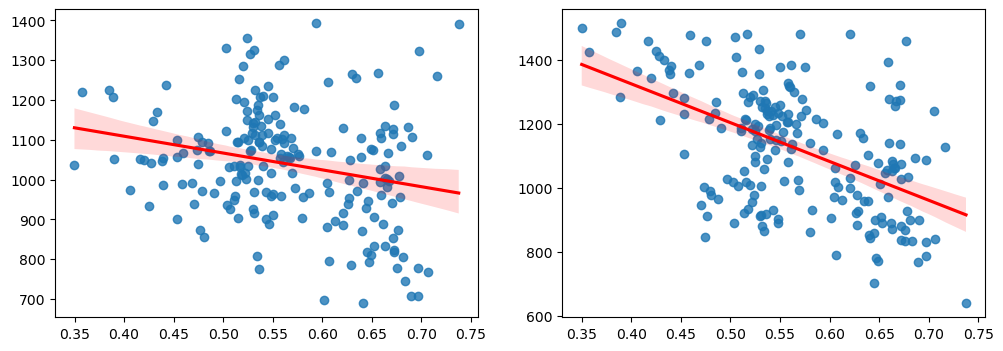

In [96]:
import seaborn as sns

fig, ax = plt.subplots(1, 2)
sns.regplot(data=monthly_df, x="utilization", y='avg_vessel_size', ax=ax[0], line_kws={'color':'red'})
sns.regplot(data=monthly_df, x="utilization", y='num_voyages', ax=ax[1], line_kws={'color':'red'})
fig.set_size_inches(12, 4)
plt.show()

In [97]:
fig = px.scatter_matrix(monthly_df,
    dimensions=["utilization", "teus", "avg_vessel_size", "num_voyages"],
    width=900,
    height=500
    )
fig.show()

In [98]:
df = (
    exports_lf
    #filter to seattle and tacoma
    .filter((pl.col('departure_port_name')=='SEATTLE')|(pl.col('departure_port_name')=='TACOMA'))
    #group by alliance and month
    .group_by('alliance', 'month')
    .agg(
        pl.col('teus').sum().alias('sum_teus'),
        pl.col('shared_teus').sum().alias('sum_shared_teus')
    )
    .with_columns(
        (pl.col('sum_shared_teus')/pl.col('sum_teus')).alias('prop_shared')
    )
    .sort(by='month')
    .collect()
)

px.line(
    df, x='month', y='prop_shared',
    color='alliance',
    title='Alliance Sharing Through Time at Northwest Seaport Alliance Ports',
    width=900,
    height=500)


We also look at the relationship between the prevalence of sharing cargo and the overall size of the port, theorizing that cargo sharing may be more common at smaller ports. 

In [99]:
port_share_df = (
    exports_lf
    .group_by('departure_port_name')
    .agg(
        (pl.col('shared_teus')).sum().alias('sum_shared_teus'),
        pl.col('teus').sum().alias('sum_teus'),
        pl.col('date_departure').unique().count().alias('service_count')
    )
    .with_columns((pl.col('sum_shared_teus')/pl.col('sum_teus')).alias('prop_shared'))
    .sort(by='sum_teus')
    .cast({'departure_port_name':pl.Utf8})
    .collect()
    .to_pandas()
)
port_share_df.head()

,departure_port_name,sum_shared_teus,sum_teus,service_count,prop_shared
0,SITKA,0.0,4.000000,1,0.0
1,CROCKETT,0.0,4.513798,1,0.0
2,HILO,0.0,4.513798,1,0.0
3,SELBY,0.0,4.513798,1,0.0
4,KETCHIKAN,0.0,9.027596,1,0.0


In [100]:
px.scatter(port_share_df,y=port_share_df.prop_shared, x=port_share_df.service_count,
        width=900,
        height=500)

In [101]:

px.scatter(port_share_df, x=port_share_df.sum_teus, y=port_share_df.prop_shared,
           color=port_share_df.departure_port_name,
           labels={'index':'Port Size Rank (ascending)'},
           title='Average % Shared Cargo by Port Size'
           )

### Sharing between Alliance Members

One potential effect of alliances is that shared capacity formerly available to all carriers becomes utilized mostly by alliance members. Since 2017, all major carriers are in alliances with other major carriers, potentially reducing the capacity for smaller carriers to move cargo on ships owned by major carriers. 

In [102]:
share_df = (
    exports_lf
    #get shared cargo col
    .with_columns(
        (pl.col('teus')*(1-pl.col('primary_cargo'))).alias('shared_teus')
    )
    .collect()
)

In [124]:
def sharing_by_carrier(lf, scac, carrier_name=None):
    '''
    ad hoc function to inspect sharing by scac over time for a given carrier
    inputs:
        scac - str - the SCAC for the carrier of interest
        carrier_name - str - the string name of the carrier of interest for plot title
    '''
    #get top sharing partners
    top_partners = (
        lf
        #get shared cargo col
        .with_columns((pl.col('teus')*(1-pl.col('primary_cargo'))).alias('shared_teus'))
        #only maersk vessels but not maersk cargo
        .filter((pl.col('vessel_owner')==scac)&(pl.col('unified_carrier_scac')!=scac))
        #group by carrier
        .group_by('unified_carrier_name')
        .agg(pl.col('shared_teus').sum())
        #filter to top 10
        .sort(by='shared_teus', descending=True)
        .limit(5)
        #retail only carriers
        .drop('shared_teus')
        #collect
        .collect()
        #convert from dataframe to series
        .to_series()
    )

    #make df for graphing
    df = (
        lf
        #only maersk vessels but not maersk cargo
        .filter((pl.col('vessel_owner')==scac)&(pl.col('unified_carrier_scac')!=scac))
        #create partners column
        .with_columns(
            pl.when(pl.col('unified_carrier_name').is_in(top_partners))
            .then(pl.col('unified_carrier_name'))
            .otherwise(pl.lit('Other Carriers'))
            .alias('partner')
        )
        #get percentages of other carriers
        .group_by('unified_carrier_name', 'partner','month')
        .agg(pl.col('teus').sum())
        .with_columns(pl.col('teus').sum().over('month').alias('total_shared'))
        .with_columns((pl.col('teus')/pl.col('total_shared')).alias('prop_shared'))
        .with_columns(pl.col('month').str.to_datetime('%Y%m'))
        #sort for plotting
        .sort(by='month')
        .cast({'partner':pl.Utf8})
        .collect()
    )
    #plot
    fig = px.bar(df, x='month', y='prop_shared', color='partner', 
                title=str('Proportion of shared cargo on '+carrier_name+' ships by Carrier') if carrier_name else str('Proportion of shared cargo on '+scac+' ships by Carrier'),
                labels={
                    'prop_shared':'Percentage of Shared Cargo',
                    'month':'Time',
                    'partner':'Carrier'
                },
                width=1100,
                height=500,
                category_orders={
                    'partner':['Other Carriers', 'SAFMARINE', 'ANL CONTAINER LINE',  'CMA-CGM','HYUNDAI', 'MEDITERRANEAN SHIPPING COMPANY']
                }
    )
    fig.add_vline(x=datetime.strptime("2015-01-01", "%Y-%m-%d").timestamp() * 1000, 
                  line_width=4, line_dash='dash',
                  annotation_text="2M Alliance begins"
                  )
    fig.show()

In [123]:
sharing_by_carrier(exports_lf, 'MLSL', 'Maersk Line')

## Defining Alliance Activity

We define *alliance activity*, i.e., how active an alliance agreement is, as the % of shared cargo represented by allied carriers on a given ship.

## Regression

The initial model for the project inspects the effects of carrier alliances on frequency of service. We estimate this using the following equation:

$$ S_{lct} = b X_{lct} + a_1 AM_{ct}PC_{lc} + a_2 AM_{ct} + a_3 PC_{lc} + \epsilon_{lct} $$

where:
- $l$ is the lane, i.e. the departure port and arrival port pair
- $c$ is the carrier
- $t$ is the time period, which we aggregate to months (e.g., May 2019)
- $S$ is the frequency of service, i.e. the number of voyages provided to that lane by the carrier in the given month. 
- $X$ are the correction variables
- $AM$ is an indicator of whether or not the carrier is part of an alliance
- $PC$ is an indicator of whether or not the lane was serviced by that carrier before the alliance took effect. 

Since our initial interest is the impact of alliances on domestic producers, we start by analysing the exports database. 

In [ ]:
#collect data into regular dataframe for analysis
df = (
    exports_lf
    #aggregate by lane, carrier, and month, counting unique departure dates to determine service frequency
    .group_by('lane_id', 'unified_carrier_scac', 'year', 'month')
    .agg(pl.col('date_departure').unique().count().alias('service_freq'))
    #rename carrier code column
    .rename({'unified_carrier_scac':'scac'})
    #cast data types
    .cast({'service_freq':pl.Int16})
    .with_columns(pl.col('month').str.to_datetime('%Y%m'))
    .collect()
)

#display
display(df.describe())
df.head()

In [ ]:

#join alliance membership data into main df
df = (
    df.join(alliances_df, on=['scac', 'year'], how='left')
    #set missing alliance membership values to null 
    .with_columns(pl.col('alliance_member').fill_null(0))
)

In [ ]:
df.head()

### Identifying whether a lane was serviced by that carrier before the alliance took effect

In [ ]:
df= (
    #get total voyages prior to joining an alliance for each lane and carrier
    df.with_columns(
        pl.when(pl.col('alliance_member')==0)
        .then(pl.col('service_freq').sum().over('lane_id', 'scac'))
        .otherwise(pl.lit(0))
        .alias('service_prior')
    )
    #simplify to 1 if any service prior to alliance, 0 otherwise
    .with_columns(
        pl.when(pl.col('service_prior').sum()>0)
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .over('lane_id', 'scac')
        .alias('service_prior')
    )
)
df.head()

## Simple OLS Regression

Leaving out any correction variables for the moment, we estimate a simple OLS regression model on the equation above. 

In [ ]:
#set dependent and independent variables
Y = df.select('service_freq').to_pandas()
X = (
    df.select('alliance_member', 'service_prior')
    .with_columns((pl.col('alliance_member')*pl.col('service_prior')).alias('alliance*prior'))
    .to_pandas()
)
#add intercept
X = sm.add_constant(X)
#instantiate model
model = sm.OLS(Y,X)
#run regression
results = model.fit()

#display
results.summary()


In [ ]:
#obtain moments for residuals
mu, std = scipy.stats.norm.fit(results.resid)

#plot resid distribution
fig, ax = plt.subplots()
sns.histplot(x=results.resid, ax=ax, stat='density', linewidth=0, kde=True)
ax.set(title='Distribution of model_OLS residuals', xlabel='residual')

#add corresponding normal curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x,mu,std)
sns.lineplot(x=x, y=p, color='red', ax=ax)
plt.show()

In [ ]:
sm.qqplot(results.resid, line='45', fit=True);

### Limitations

1. It's broke. 
2. The simplistic method of identifying when a carrier had previously serviced that lane results in a uninteresting alliance*prior interaction term. We need to decide on a better means of identification. 
3. Complete alliance membership data only goes back to 2017; we need to update that table. 